In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import numpy as np
import pandas as pd
import os
import sys
import cv2
import albumentations
from fastai import *
from fastai.vision import *
from fastai.vision import models
from fastai.callbacks.hooks import *
import random

from fastai.torch_core import flatten_model
from torchvision.models import *
import pretrainedmodels

In [3]:
albumentations_transform = albumentations.Compose([
    albumentations.RandomRotate90(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.Flip(p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
    ],p=0.8),
    albumentations.GaussNoise(p=0.05),
    albumentations.augmentations.transforms.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=20, always_apply=False, p=0.5),
    albumentations.RandomGamma(gamma_limit=(80, 200), always_apply=True, p=1),
])

albumentations_transform_validation = albumentations.Compose([
    #albumentations.RandomRotate90(p=0.5),
    #albumentations.Transpose(p=0.5),
])

## Augmentations

When transforming the same area from two different levels, we should use the same augmentations. Test this with setting the same random states in each row.

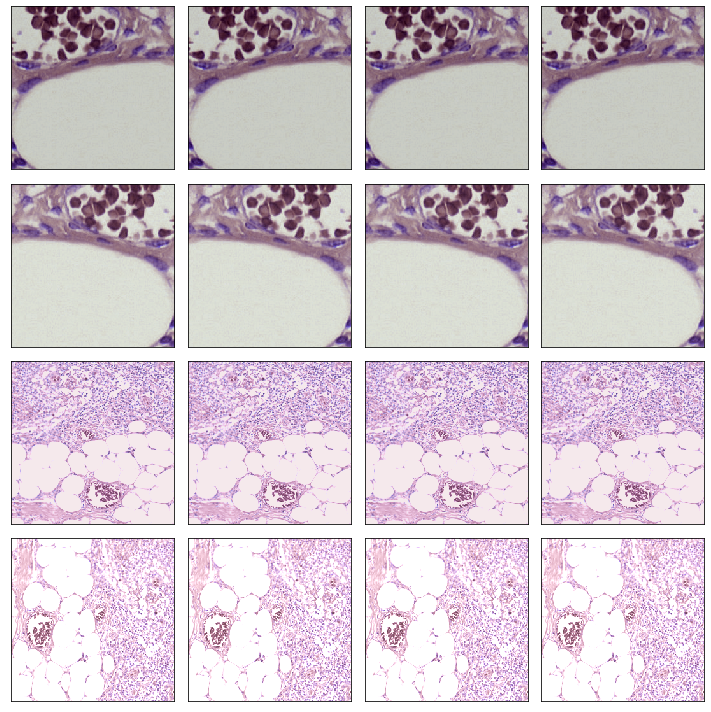

In [4]:
# sample image
img1 = cv2.imread('data/norm_patches/1066240043904_0.png')
img2 = cv2.imread('data/norm_patches/1066240043904_3.png')

fig, ax = plt.subplots(4,4, figsize=(10,10))
for i in range(4):
    random_state = random.getstate()
    for j in range(4):
        random.setstate(random_state)
        augmented = albumentations_transform(image=img1) if i < 2 else albumentations_transform(image=img2)
        ax[i,j].imshow(augmented['image'])
        ax[j, i].xaxis.set_major_locator(plt.NullLocator())
        ax[j, i].yaxis.set_major_locator(plt.NullLocator())
plt.tight_layout()

## Multilevel dataloader
First, we need a way to yield two image inputs from a data loder.

In [5]:
def loadDfForFold(fold_index = 0):
    assert ((fold_index >= 0) and (fold_index <= 3)), "fold index must be between 0 and 3"
    df = pd.read_csv('data/training/train_val.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
    df['is_valid'] = False
    df_test = pd.read_csv('data/training/test.csv').set_index('Unnamed: 0').set_index('patchId',drop=False)
    df_test['is_valid'] = True
    return pd.concat([df,df_test])

In [6]:
df = loadDfForFold(0)
sz = 256
BATCH_SIZE = 32
NUM_WORKERS = 16
model_name = '20190807-13-normalized_multilevel3_Test'

In [7]:
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj,self.data = (img1,img2),[-1+2*img1.data,-1+2*img2.data]
        
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        self.data = [-1+2*self.img1.data,-1+2*self.img2.data]
        return self
    
    def to_one(self): 
        return Image(0.5+torch.cat(self.data,2)/2)
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(9,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`. 
        `kwargs` are passed to the show method."""
        figsize = fai.ifnone(figsize, (6,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
            x.show(ax=axs[i,0], y=y, **kwargs)
            x.show(ax=axs[i,1], y=z, **kwargs)
    
    def __repr__(self):
        return f'{self.__class__.__name__}{(self.img1.shape, self.img2.shape)}'

In [8]:
class ImageTupleList(ImageList):
    def __init__(self, items, df_copy=None, validation_colname="", data_dir='',data_suffix=[],last_fn='', **kwargs):
        super().__init__(items, **kwargs)
        self.df_copy,self.validation_colname,self.data_dir,self.data_suffix = df_copy,validation_colname,data_dir,data_suffix
        self.last_fn = last_fn
        if(df_copy is None):
            print('Empty df copy')
        self.copy_new.append('df_copy')
        self.copy_new.append('validation_colname')
        self.copy_new.append('data_dir')
        self.copy_new.append('data_suffix')
        self.copy_new.append('last_fn')
    
    def get(self, i):
        # keep random state to apply the same augmentations for both images
        random_state = random.getstate()
        img1 = super().get(i)
        random.setstate(random_state)
        img2 = self.open(self.last_fn)
        return ImageTuple(img1, img2)
    
    def open(self, fn)->Image:
        self.last_fn = fn.replace(self.data_suffix[0], self.data_suffix[1])
        img = cv2.imread(fn)
        # Apply transformations
        augmented = albumentations_transform_validation(image=img) if (self.df_copy.loc[int(fn.strip(self.data_dir).replace(self.data_suffix[0],'').replace(self.data_suffix[1],''))][self.validation_colname]).any() else albumentations_transform(image=img)
        # Convert numpy array to tensor
        return vision.Image(px=pil2tensor(augmented['image']/255., np.float32))
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))
    
    @classmethod
    def from_df_custom(cls, df:DataFrame, path:PathOrStr, cols:IntsOrStrs=0, folder:PathOrStr=None, suffix=[], **kwargs)->'ItemList':
        "Get the filenames in `cols` of `df` with `folder` in front of them, `suffix` at the end."
        suffix = suffix or []
        res = super().from_df(df, path=path, cols=cols, **kwargs, data_dir=path, data_suffix=suffix)
        pref = f'{res.path}{os.path.sep}'
        if folder is not None: pref += f'{folder}{os.path.sep}'
        res.items = np.char.add(np.char.add('', res.items.astype(str)), '_0.png')
        return res
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

In [9]:
multiLevelList = (ImageTupleList.from_df_custom(path='data/norm_patches/',
                                            df=df,
                                            suffix=['_0.png','_3.png'], 
                                            df_copy=df,
                                            validation_colname='is_valid')
                    .split_from_df('is_valid')
                    #How to split in train/valid? CV index
                    .label_from_df(cols='tumorLabel')
                    #Where are the labels?
                    .transform(tfms=[[],[]], size=sz)
                    # We have our custom transformations implemented in the image loader but we could apply transformations also here
                    # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
                    .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS))
                    # convert to databunch

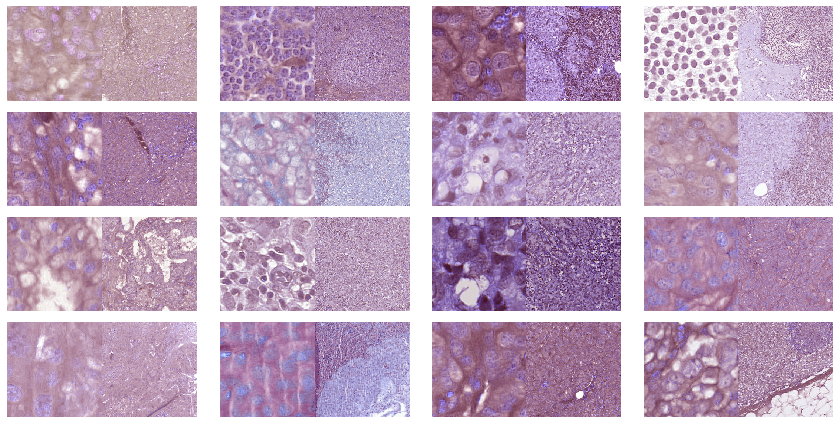

In [10]:
multiLevelList.show_batch(rows=4,ds_type=DatasetType.Train)

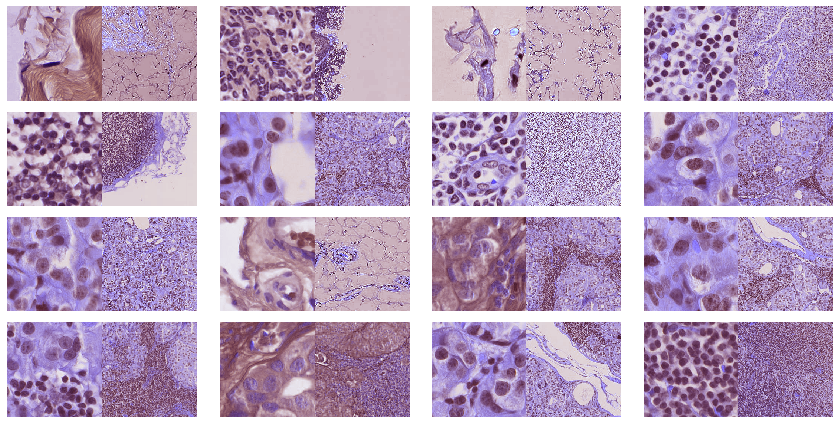

In [11]:
multiLevelList.show_batch(rows=4,ds_type=DatasetType.Valid)

## Model

In [12]:
def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []
        
class FakeData:
    def __init__(self):
        self.c = 2
        self.path = ''    
        self.device = None
        self.loss_func = CrossEntropyFlat(axis=1)

In [13]:
# we wrap cadene model to pytorch models format
def se_resnext101_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext101_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

In [14]:
# we wrap cadene model to pytorch models format
def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.__dict__['se_resnext50_32x4d'](pretrained=pretrained)
    all_layers = list(model.children())
    return nn.Sequential(*all_layers)

In [15]:
arch_summary(se_resnext50_32x4d)

(0) Sequential  : 4   layers (total: 4)
(1) Sequential  : 38  layers (total: 42)
(2) Sequential  : 50  layers (total: 92)
(3) Sequential  : 74  layers (total: 166)
(4) Sequential  : 38  layers (total: 204)
(5) AvgPool2d   : 1   layers (total: 205)
(6) Linear      : 1   layers (total: 206)


In [16]:
arch_summary(se_resnext101_32x4d)

(0) Sequential  : 4   layers (total: 4)
(1) Sequential  : 38  layers (total: 42)
(2) Sequential  : 50  layers (total: 92)
(3) Sequential  : 278 layers (total: 370)
(4) Sequential  : 38  layers (total: 408)
(5) AvgPool2d   : 1   layers (total: 409)
(6) Linear      : 1   layers (total: 410)


In [17]:
class MultiLevelModel(nn.Module):
    def __init__(self):
        super().__init__()
        # focus encoder outputs more features that are also more relevant to the label
        self.focus_encoder = nn.Sequential(create_body(se_resnext101_32x4d, pretrained=True, cut=-2), nn.AdaptiveAvgPool2d(1))
                                          
        # context encoder is a lighter CNN that outputs less features from the surrounding area
        self.context_encoder = nn.Sequential(create_body(se_resnext50_32x4d, pretrained=True, cut=-2), nn.AdaptiveAvgPool2d(1))
   
        # head comes after concatenating the encoder outputs
        head_inp_sz = num_features_model(self.context_encoder) + num_features_model(self.focus_encoder)

        self.head = create_head(nf=head_inp_sz, nc=2 , ps=0.9, lin_ftrs=[2048,512])[2:]

    def forward(self, x1, x2):
        forward_1 = torch.cat(
            (
                self.focus_encoder(x1),
                self.context_encoder(x2)
            ),
            1
        )
        forward_1 = torch.reshape(forward_1,(forward_1.shape[0], -1))
        forward_2 = self.head(forward_1)
        return forward_2

In [18]:
create_head(nf=2000, nc=2 , ps=0.9, lin_ftrs=[2048,512])[2:]

Sequential(
  (2): BatchNorm1d(2000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.45)
  (4): Linear(in_features=2000, out_features=2048, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.45)
  (8): Linear(in_features=2048, out_features=512, bias=True)
  (9): ReLU(inplace)
  (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.9)
  (12): Linear(in_features=512, out_features=2, bias=True)
)

In [19]:
loss_func = nn.CrossEntropyLoss()
learner = Learner(multiLevelList, MultiLevelModel(),loss_func=loss_func, metrics=[accuracy])

In [20]:
learner.model = nn.DataParallel(learner.model)

In [22]:
#learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


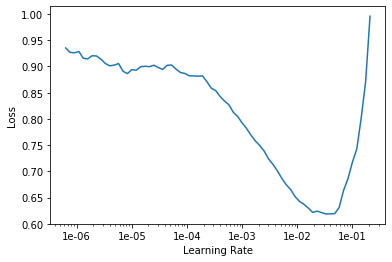

In [23]:
#learner.recorder.plot()

In [21]:
learner.model

DataParallel(
  (module): MultiLevelModel(
    (focus_encoder): Sequential(
      (0): Sequential(
        (0): Sequential(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
        )
        (1): Sequential(
          (0): SEResNeXtBottleneck(
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

## Train

In [22]:
def getDataBunch(fold_index = 0):
    df = loadDfForFold(fold_index)
    return (ImageTupleList.from_df_custom(path='data/norm_patches/',
                                            df=df,
                                            suffix=['_0.png','_3.png'], 
                                            df_copy=df,
                                            validation_colname='is_valid')
                    .split_from_df('is_valid')
                    #How to split in train/valid? CV index
                    .label_from_df(cols='tumorLabel')
                    #Where are the labels?
                    .transform(tfms=[[],[]], size=sz)
                    # We have our custom transformations implemented in the image loader but we could apply transformations also here
                    # Even though we don't apply transformations here, we set two empty lists to tfms. Train and Validation augmentations
                    .databunch(bs=BATCH_SIZE, num_workers=NUM_WORKERS))
                    # convert to databunch

In [23]:
def getLearner(multiLevelList):
    loss_func = nn.CrossEntropyLoss()
    learner = Learner(multiLevelList, 
                      MultiLevelModel(),
                      loss_func=loss_func, 
                      metrics=[accuracy], 
                      callback_fns=ShowGraph)
    
    return learner

In [ ]:
from sklearn.metrics import roc_curve, auc

# hyperparameters
head_training_epochs = 1
head_training_lr = 1e-3

# saved for validation
interp_list = []
preds_list = []
y_list = []
loss_list = []
acc_list = []

tpr_list = []
fpr_list = []
roc_auc_list = []

recorder_stage1_list = []

for fold in range(3):
    print("##########################")
    print("Start training CV fold " + str(fold))
    print("##########################")
    
    # get fold databunch
    fold_databunch = getDataBunch(fold_index=fold)
    
    # init new learner
    learner = getLearner(fold_databunch)
    
    print("Training stage-1 of test " + str(fold))
    
    # warmup with lr finder
    learner.lr_find()
    # plot lr finder result
    learner.recorder.plot()
    
    learner.fit_one_cycle(head_training_epochs,
                      head_training_lr)
    
    learner.recorder.plot_losses()
    # save stage 1
    learner.save(model_name + '_test' + str(fold) + '_stage-1')
    
    recorder_stage1_list.append(learner.recorder)
    
    #print("Training stage-2 of fold " + str(fold))
    
    # unfreeze and train some more
    #learner.unfreeze()
    
    # warmup with lr finder
    #learner.lr_find()
    # plot lr finder result
    #learner.recorder.plot()
    
    #learner.fit_one_cycle(finetune_training_epochs,
    #                      finetune_training_lr)
    
    #learner.recorder.plot_losses()
    
    # save stage 2
    #learner.save(model_name + '_fold' + str(fold) + '_stage-2')
    
    #recorder_stage2_list.append(learner.recorder)
    
    # get preds for validation 
    preds,y, loss = learner.get_preds(with_loss=True)
    acc = accuracy(preds, y)
    print('The accuracy of the test {1} model is {0} %.'.format(acc, fold))
    
    interp = ClassificationInterpretation.from_learner(learner)
    
    preds_list.append(preds)
    y_list.append(y)
    loss_list.append(loss)
    acc_list.append(acc)
    interp_list.append(interp)
    
    
    # probs from log preds
    probs = np.exp(preds[:,1])
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)
    
    fpr_list.append(fpr)
    tpr_list.append(tpr)

    # Compute ROC area
    roc_auc = auc(fpr, tpr)
    print('ROC area of the test {1} is {0}'.format(roc_auc, fold))
    
    roc_auc_list.append(roc_auc)

##########################
Start training CV fold 0
##########################
Training stage-1 of test 0


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,time


## Visualization & validation

In [ ]:
for i, recorder in enumerate(recorder_stage1_list):
    recorder.plot_losses()

In [ ]:
for i, interp in enumerate(interp_list):
    interp.plot_confusion_matrix(normalize=True, title="Fold {0}:".format(i))

In [ ]:
for fold , acc in enumerate(acc_list):
    print('The accuracy of the test {1} model is {0} %.'.format(acc*100, fold))

In [ ]:
for fold , auc in enumerate(roc_auc_list):
    print('The AUC of the test {1} model is {0} %.'.format(auc*100, fold))
print('The average AUC of all tests is {0} %'.format(np.asarray(roc_auc_list).mean()*100))

In [ ]:
from random import randint
def plot_overview(interp:ClassificationInterpretation, classes=['Normal','Tumor'], title_txt=""):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,7))
    fig.suptitle('Predicted / Actual / Probability ' + title_txt,fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.to_one().data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.to_one().data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.to_one().data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

In [ ]:
for i, interp in enumerate(interp_list):
    plot_overview(interp, ['Normal','Tumor'], title_txt=",Fold {0}:".format(i))

## Activations

In [ ]:
from fastai.callbacks.hooks import *

# hook into forward pass
def hooked_backward_focus(m, oneBatch, cat, depth=0):
    # we hook into the convolutional part = m[0] of the model
    if (depth == None):
        with hook_output(m.focus_encoder[0]) as hook_a: 
            with hook_output(m.focus_encoder[0], grad=True) as hook_g:
                preds = m(oneBatch[0],oneBatch[1])
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    else:
        with hook_output(m.focus_encoder[0][depth]) as hook_a: 
            with hook_output(m.focus_encoder[0][depth], grad=True) as hook_g:
                preds = m(oneBatch[0],oneBatch[1])
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    
# hook into forward pass
def hooked_backward_context(m, oneBatch, cat, depth=0):
    # we hook into the convolutional part = m[0] of the model
    if (depth == None):
        with hook_output(m.context_encoder[0]) as hook_a: 
            with hook_output(m.context_encoder[0], grad=True) as hook_g:
                preds = m(oneBatch[0],oneBatch[1])
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    else:
        with hook_output(m.context_encoder[0][depth]) as hook_a: 
            with hook_output(m.context_encoder[0][depth], grad=True) as hook_g:
                preds = m(oneBatch[0],oneBatch[1])
                preds[0,int(cat)].backward()
        return hook_a,hook_g

In [ ]:
def colorize_binary_image(img, color_channel:int=1, max_value=1):
    '''
    Colorize binary image to set color channel.
    Only 0 and 1 works with the color channel'''
    empty_c = np.zeros((img.shape[0], img.shape[1], 1), dtype=np.uint8) 
    alpha_c = np.ones((img.shape[0], img.shape[1], 1), dtype=np.uint8)
    sc_factor = 255/5e-6 if max_value < 1e-8 else 255/max_value
    img *= sc_factor
    img = torch.clamp(img, 0, 255, out=None)
    img = img.reshape((img.shape[0], img.shape[1], 1)).numpy().astype(np.uint8)
    alpha_img = np.concatenate([empty_c, img, empty_c, alpha_c], axis=2) if color_channel == 1 else np.concatenate([ img, empty_c, empty_c, alpha_c], axis=2)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            alpha_img[x, y, 3] = 0 if alpha_img[x, y, color_channel] == 0 else alpha_img[x, y, color_channel]*2//3
    return alpha_img

In [ ]:
# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index, databunch, learner, depth=0 ,manual_scaler=None, focus=True):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learner.model.eval()
    tensorImgTuple,cl = databunch.valid_ds[val_index]
    # create a batch from the one item
    oneBatch,_ = databunch.one_item(tensorImgTuple)
    #oneBatch_imTuple = ImageTuple(databunch.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(tensorImgTuple.img1.data), cv2.COLOR_RGB2GRAY) if focus else cv2.cvtColor(image2np(tensorImgTuple.img2.data), cv2.COLOR_RGB2GRAY)
    colorImage = image2np(tensorImgTuple.img1.data) if focus else image2np(tensorImgTuple.img2.data)
    
    # attach hooks
    #hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    hook_a_tumor,hook_g_tumor = hooked_backward_focus(m, oneBatch, 1, depth) if focus else hooked_backward_context(m, oneBatch, 1, depth)
    # get convolutional activations and average from channels
    acts_tumor = hook_a_tumor.stored[0].cpu()

    # Grad-CAM
    grad_tumor = hook_g_tumor.stored[0][0].cpu()
    grad_chan_tumor = grad_tumor.mean(1).mean(1)
    mult_tumor = F.relu((acts_tumor*grad_chan_tumor[...,None,None]).mean(0))
    
    hook_a_normal,hook_g_normal = hooked_backward_focus(m, oneBatch, 0, depth) if focus else hooked_backward_context(m, oneBatch, 0, depth)
    # get convolutional activations and average from channels
    acts_normal = hook_a_normal.stored[0].cpu()

    # Grad-CAM
    grad_normal = hook_g_normal.stored[0][0].cpu()
    grad_chan_normal = grad_normal.mean(1).mean(1)
    mult_normal = F.relu((acts_normal*grad_chan_normal[...,None,None]).mean(0))
    
    scaler = max(mult_tumor.max(), mult_normal.max())
    if (manual_scaler is not None):
        scaler = manual_scaler
    
    return (colorize_binary_image(mult_tumor, 0, max_value=scaler),
            colorize_binary_image(mult_normal, 1, max_value=scaler),
            colorImage) #cvIm

In [ ]:
# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, databunch, learner, classes=['Negative','Tumor'], title_txt="", depth=0, focus=True):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #mask_alpha = 0.3
    tissue_alpha = 0.75
    manual_scaler = None# 1e-4
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,13))
    if depth != None:
        fig.suptitle('Layer depth: {0}\nClass activation map where: Green=Normal, Red=Tumor\nPredicted / Actual / Probability '.format(depth) + title_txt,fontsize=20)
    else:
            fig.suptitle('Class activation map where: Green=Normal, Red=Tumor\nPredicted / Actual / Probability ' + title_txt,fontsize=20)    
    # Random
    for i in range(2):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act_tumor, act_normal, im = getHeatmap(idx, databunch, learner, depth, manual_scaler,focus=True)
        H,W = im.shape[:2]
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i*2].imshow(im, alpha=tissue_alpha)
        #ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i*2].imshow(act_tumor, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[0,i*2].imshow(act_normal, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[0,i*2].set_xticks([])
        ax[0,i*2].set_yticks([])
        ax[0,i*2].set_title('Focus\n' +  f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
        
        act_tumor, act_normal, im = getHeatmap(idx, databunch, learner, depth, manual_scaler,focus=False)
        ax[0,i*2+1].imshow(im, alpha=tissue_alpha)
        #ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i*2+1].imshow(act_tumor, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[0,i*2+1].imshow(act_normal, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[0,i*2+1].set_xticks([])
        ax[0,i*2+1].set_yticks([])
        ax[0,i*2+1].set_title('Context\n' +  f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(2):
        idx = tl_idx[i]
        act_tumor, act_normal, im = getHeatmap(idx, databunch, learner, depth, manual_scaler,focus=True)
        H,W = im.shape[:2]
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i*2].imshow(im, alpha=tissue_alpha)
        ax[1,i*2].imshow(act_tumor, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[1,i*2].imshow(act_normal, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[1,i*2].set_xticks([])
        ax[1,i*2].set_yticks([])
        ax[1,i*2].set_title('Focus\n' +  f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
        
        act_tumor, act_normal, im = getHeatmap(idx, databunch, learner, depth, manual_scaler,focus=False)
        H,W = im.shape[:2]
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i*2+1].imshow(im, alpha=tissue_alpha)
        ax[1,i*2+1].imshow(act_tumor, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[1,i*2+1].imshow(act_normal, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[1,i*2+1].set_xticks([])
        ax[1,i*2+1].set_yticks([])
        ax[1,i*2+1].set_title('Context\n' +  f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
        
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(2):
        idx = tl_idx[len(tl_idx) - i - 1]
        act_tumor, act_normal, im = getHeatmap(idx, databunch, learner, depth, manual_scaler,focus=True)
        H,W = im.shape[:2]
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i*2].imshow(im, alpha=tissue_alpha)
        #ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i*2].imshow(act_tumor, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[2,i*2].imshow(act_normal, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[2,i*2].set_xticks([])
        ax[2,i*2].set_yticks([])
        ax[2,i*2].set_title('Focus\n' +  f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
        
        act_tumor, act_normal, im = getHeatmap(idx, databunch, learner, depth, manual_scaler,focus=False)
        H,W = im.shape[:2]
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i*2+1].imshow(im, alpha=tissue_alpha)
        #ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i*2+1].imshow(act_tumor, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[2,i*2+1].imshow(act_normal, extent=(0,H,W,0),
              interpolation='bilinear')
        ax[2,i*2+1].set_xticks([])
        ax[2,i*2+1].set_yticks([])
        ax[2,i*2+1].set_title('Context\n' +  f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

In [ ]:
for i, interp in enumerate(interp_list):
    # get fold databunch
    fold_databunch = getDataBunch(fold_index=i)
    
    # init new learner
    learner = getLearner(fold_databunch)
    
    plot_heatmap_overview(interp, 
                          fold_databunch, 
                          learner, 
                          ['Normal','Tumor'], 
                          title_txt=",Fold {0}:".format(i), 
                          depth=None, 
                          focus=False)
    

In [ ]:
plt.figure()
color_str = ['darkorange', 'blueviolet', 'firebrick', 'steelblue']
for i, f in enumerate(fpr_list):
    plt.plot(fpr_list[i], tpr_list[i], color=color_str[i], label='Fold %d (area = %0.2f)' % (i, roc_auc_list[i]))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='random baseline (area = 0.5)')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [ ]:
learner.model.eval()

In [ ]:
learner.model.eval().focus_encoder

In [ ]:
learner.model.eval().context_encoder[0]

In [ ]:
learner.model.eval().head